# Chapter 8 - Movie Review Example

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas

In [3]:
d = pandas.read_csv("data/movie_reviews.tsv", delimiter="\t")

In [6]:
# Holdout split
split = 0.7
d_train = d[:int(split*len(d))]
d_test = d[int((1-split)*len(d)):]

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
features = vectorizer.fit_transform(d_train.review)

In [8]:
i = 45000
j = 10
words = vectorizer.get_feature_names()[i:i+10]
pandas.DataFrame(features[j:j+7,i:i+10].todense(), columns=words)

,producer,producer9and,producers,produces,producing,product,production,productions,productive,productively
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0


In [9]:
float(features.getnnz())*100 / (features.shape[0]*features.shape[1])

0.21303978814816443

In [10]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB()
model1.fit(features, d_train.sentiment)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
pred1 = model1.predict_proba(vectorizer.transform(d_test.review))

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
def performance(y_true, pred, color="g", ann=True):
    acc = accuracy_score(y_true, pred[:,1] > 0.5)
    auc = roc_auc_score(y_true, pred[:,1])
    fpr, tpr, thr = roc_curve(y_true, pred[:,1])
    plot(fpr, tpr, color, linewidth="3")
    xlabel("False positive rate")
    ylabel("True positive rate")
    if ann:
        annotate("Acc: %0.2f" % acc, (0.1,0.8), size=14)
        annotate("AUC: %0.2f" % auc, (0.1,0.7), size=14)

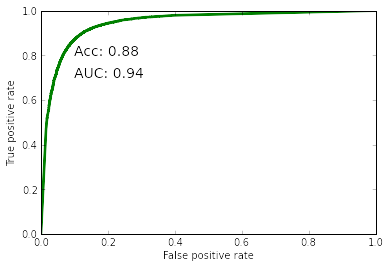

In [13]:
performance(d_test.sentiment, pred1)

## tf-idf features

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(d_train.review)

(0.5, 1)

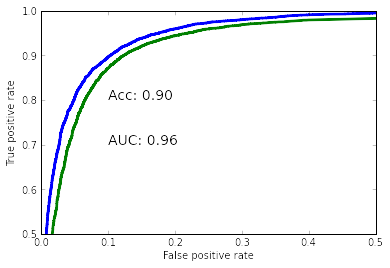

In [16]:
pred2 = model1.predict_proba(vectorizer.transform(d_test.review))
performance(d_test.sentiment, pred1, ann=False)
performance(d_test.sentiment, pred2, color="b")
xlim(0,0.5)
ylim(0.5,1)

## Parameter optimization

In [17]:
param_ranges = {
    "max_features": [10000, 30000, 50000, None],
    "min_df": [1,2,3],
    "nb_alpha": [0.01, 0.1, 1.0]
}

In [18]:
def build_model(max_features=None, min_df=1, nb_alpha=1.0, return_preds=False):
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
    features = vectorizer.fit_transform(d_train.review)
    model = MultinomialNB(alpha=nb_alpha)
    model.fit(features, d_train.sentiment)
    pred = model.predict_proba(vectorizer.transform(d_test.review))
    res = {
        "max_features": max_features,
        "min_df": min_df,
        "nb_alpha": nb_alpha,
        "auc": roc_auc_score(d_test.sentiment, pred[:,1])
    }
    if return_preds:
        res['preds'] = pred
    return res

In [19]:
from itertools import product
results = []
for p in product(*param_ranges.values()): 
    res = build_model(**dict(zip(param_ranges.keys(), p)))
    results.append( res )
    print res

{'max_features': 10000, 'nb_alpha': 0.01, 'auc': 0.9452288421633197, 'min_df': 1}
{'max_features': 10000, 'nb_alpha': 0.01, 'auc': 0.94534598458416985, 'min_df': 2}
{'max_features': 10000, 'nb_alpha': 0.01, 'auc': 0.94528327613097241, 'min_df': 3}
{'max_features': 10000, 'nb_alpha': 0.1, 'auc': 0.94535170553865855, 'min_df': 1}
{'max_features': 10000, 'nb_alpha': 0.1, 'auc': 0.94544454696447144, 'min_df': 2}
{'max_features': 10000, 'nb_alpha': 0.1, 'auc': 0.9453788017032404, 'min_df': 3}
{'max_features': 10000, 'nb_alpha': 1.0, 'auc': 0.9451069192188557, 'min_df': 1}
{'max_features': 10000, 'nb_alpha': 1.0, 'auc': 0.94514844185428892, 'min_df': 2}
{'max_features': 10000, 'nb_alpha': 1.0, 'auc': 0.94509984639498434, 'min_df': 3}
{'max_features': 30000, 'nb_alpha': 0.01, 'auc': 0.96420321713304125, 'min_df': 1}
{'max_features': 30000, 'nb_alpha': 0.01, 'auc': 0.96356040650699282, 'min_df': 2}
{'max_features': 30000, 'nb_alpha': 0.01, 'auc': 0.96297866511088048, 'min_df': 3}
{'max_feature

In [20]:
opt = pandas.DataFrame(results)

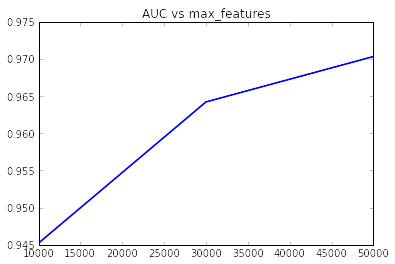

In [21]:
mf_idx = [0,9,18,27]
plot(opt.max_features[mf_idx], opt.auc[mf_idx], linewidth=2)
title("AUC vs max_features")

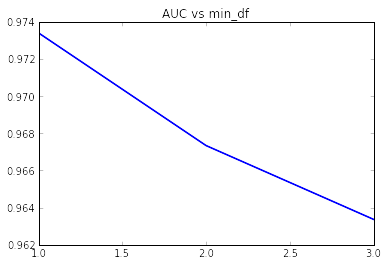

In [22]:
mdf_idx = [27,28,29]
plot(opt.min_df[mdf_idx], opt.auc[mdf_idx], linewidth=2)
title("AUC vs min_df")

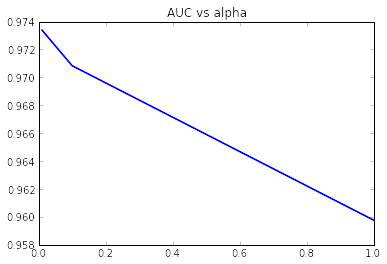

In [23]:
nba_idx = [27,30,33]
plot(opt.nb_alpha[nba_idx], opt.auc[nba_idx], linewidth=2)
title("AUC vs alpha")

(0.5, 1)

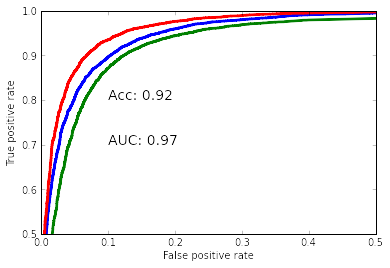

In [24]:
pred3 = build_model(nb_alpha=0.01, return_preds=True)['preds']
performance(d_test.sentiment, pred1, ann=False)
performance(d_test.sentiment, pred2, color="b", ann=False)
performance(d_test.sentiment, pred3, color="r")
xlim(0,0.5)
ylim(0.5,1)

## Random Forest

In [25]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=3, max_features=30000, norm="l2")
features = vectorizer.fit_transform(d_train.review)

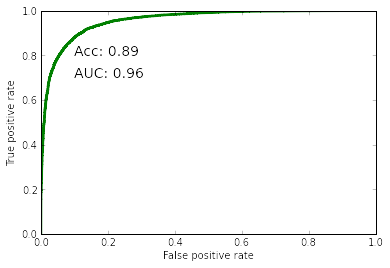

In [26]:
model3 = MultinomialNB()
model3.fit(features, d_train.sentiment)
pred3 = model3.predict_proba(vectorizer.transform(d_test.review))
performance(d_test.sentiment, pred3)

In [27]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=100)
model2.fit(features, d_train.sentiment)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

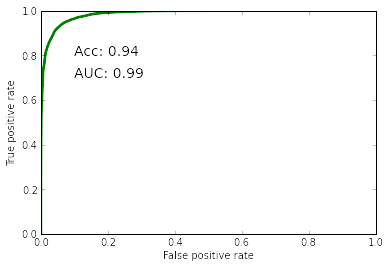

In [28]:
pred2 = model2.predict_proba(vectorizer.transform(d_test.review))
performance(d_test.sentiment, pred2)

## Word2Vec

In [29]:
import re, string
stop_words = set(['all', "she'll", "don't", 'being', 'over', 'through', 'yourselves', 'its', 'before', "he's", "when's", "we've", 'had', 'should', "he'd", 'to', 'only', "there's", 'those', 'under', 'ours', 'has', "haven't", 'do', 'them', 'his', "they'll", 'very', "who's", "they'd", 'cannot', "you've", 'they', 'not', 'during', 'yourself', 'him', 'nor', "we'll", 'did', "they've", 'this', 'she', 'each', "won't", 'where', "mustn't", "isn't", "i'll", "why's", 'because', "you'd", 'doing', 'some', 'up', 'are', 'further', 'ourselves', 'out', 'what', 'for', 'while', "wasn't", 'does', "shouldn't", 'above', 'between', 'be', 'we', 'who', "you're", 'were', 'here', 'hers', "aren't", 'by', 'both', 'about', 'would', 'of', 'could', 'against', "i'd", "weren't", "i'm", 'or', "can't", 'own', 'into', 'whom', 'down', "hadn't", "couldn't", 'your', "doesn't", 'from', "how's", 'her', 'their', "it's", 'there', 'been', 'why', 'few', 'too', 'themselves', 'was', 'until', 'more', 'himself', "where's", "i've", 'with', "didn't", "what's", 'but', 'herself', 'than', "here's", 'he', 'me', "they're", 'myself', 'these', "hasn't", 'below', 'ought', 'theirs', 'my', "wouldn't", "we'd", 'and', 'then', 'is', 'am', 'it', 'an', 'as', 'itself', 'at', 'have', 'in', 'any', 'if', 'again', 'no', 'that', 'when', 'same', 'how', 'other', 'which', 'you', "shan't", 'our', 'after', "let's", 'most', 'such', 'on', "he'll", 'a', 'off', 'i', "she'd", 'yours', "you'll", 'so', "we're", "she's", 'the', "that's", 'having', 'once'])

def tokenize(docs):
    pattern = re.compile('[\W_]+', re.UNICODE)
    sentences = []
    for d in docs:
        sentence = d.lower().split(" ") 
        sentence = [pattern.sub('', w) for w in sentence]
        sentences.append( [w for w in sentence if w not in stop_words] )
    return sentences

In [30]:
print list(stop_words)

['all', "she'll", "don't", 'being', 'over', 'through', 'yourselves', 'its', 'before', "he's", "when's", "we've", 'had', 'should', "he'd", 'to', 'only', "there's", "here's", 'under', 'ours', 'has', "haven't", 'do', 'them', 'his', 'above', 'very', "who's", "they'd", 'cannot', "you've", 'they', 'not', 'during', 'him', 'nor', "we'll", 'did', "they've", 'this', 'she', 'each', "won't", 'where', "mustn't", "isn't", "i'll", "why's", 'because', "you'd", 'doing', 'theirs', 'some', "hasn't", 'are', 'further', 'ourselves', 'out', 'what', 'for', 'herself', 'below', 'does', "shouldn't", "they'll", 'between', 'be', 'we', 'after', "doesn't", 'here', 'hers', "aren't", 'by', 'both', 'about', 'her', 'of', 'could', 'against', "i'd", "weren't", "i'm", 'or', "can't", 'own', 'into', 'yourself', 'down', "hadn't", "couldn't", 'your', "you're", 'from', "how's", 'would', 'their', "it's", 'there', 'been', "he'll", 'whom', 'too', 'themselves', 'was', 'until', 'more', 'himself', "i've", 'am', "what's", 'but', 'it',

In [31]:
sentences = tokenize(d_train.review)

In [33]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences, size=300, window=10, min_count=1, sample=1e-3, workers=2)

In [34]:
model.init_sims(replace=True)

In [35]:
model['movie']

array([  3.68031524e-02,  -1.73313618e-02,   2.39172988e-02,
         2.63126623e-02,  -2.09560362e-03,   2.88584847e-02,
         1.84983388e-02,   1.61847845e-02,   3.55088450e-02,
        -1.09551460e-01,   8.66681430e-03,   5.40465722e-03,
         3.01059918e-04,  -6.86682537e-02,   9.07223746e-02,
        -2.10372563e-02,   3.71289365e-02,   7.52746388e-02,
         2.14488988e-04,  -1.00362170e-02,  -1.01014741e-01,
         1.02308214e-01,   3.20761763e-02,  -5.46756908e-02,
        -1.42806098e-02,   5.29203713e-02,   6.76437244e-02,
         4.52545471e-02,  -3.38600017e-02,  -9.30002108e-02,
         2.45192088e-02,   5.53836077e-02,  -7.16699800e-03,
         5.90483360e-02,  -8.47217366e-02,   6.08438440e-02,
        -7.18232915e-02,   4.67804708e-02,   1.32195026e-01,
         1.17428429e-01,  -4.01911624e-02,   6.89821271e-03,
         2.51749437e-02,   2.66396683e-02,   3.70586081e-03,
         1.63978413e-02,   4.36227731e-02,  -7.04589635e-02,
        -1.55292740e-02,

In [36]:
def featurize_w2v(model, sentences):
    f = zeros((len(sentences), model.vector_size))
    for i,s in enumerate(sentences):
        for w in s:
            try:
                vec = model[w]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        f[i,:] = f[i,:] / len(s)
    return f

In [37]:
features_w2v = featurize_w2v(model, sentences)

In [38]:
model4 = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model4.fit(features_w2v, d_train.sentiment)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
test_sentences = tokenize(d_test.review)

In [40]:
test_features_w2v = featurize_w2v(model, test_sentences)

In [41]:
pred4 = model4.predict_proba(test_features_w2v)

(0.6, 1)

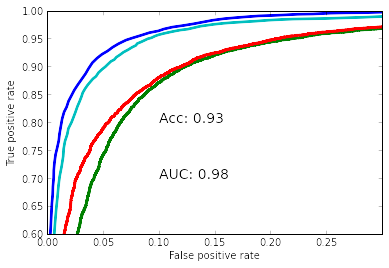

In [42]:
performance(d_test.sentiment, pred1, ann=False)
performance(d_test.sentiment, pred2, color="b", ann=False)
performance(d_test.sentiment, pred3, color="r", ann=False)
performance(d_test.sentiment, pred4, color="c")
xlim(0,0.3)
ylim(0.6,1)

In [48]:
examples = [
        "This movie is bad",
        "This movie is great",
        "I was going to say something awesome, but I simply can't because the movie is so bad.",
        "I was going to say something awesome or great or good, but I simply can't because the movie is so bad.",
        "It might have bad actors, but everything else is good."
    ]
example_feat4 = featurize_w2v(model, tokenize(examples))
model4.predict(example_feat4)

array([0, 1, 0, 0, 0])